<a href="https://colab.research.google.com/github/iliaxant/DIP_HW_2_DCT_compression/blob/main/DIP_HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ψηφιακή Επεξεργασία Εικόνας**

## 2η Εργαστηριακή Εργασία - Ακαδημαικό έτος 2025-2026

## Ηλίας Ξανθόπουλος 58545

## GitHub Repo: https://github.com/iliaxant/DIP_HW_2_DCT_compression

## **Μέρος 0**: Προετοιμασία (Skip)

Mounting Google Drive και φόρτωση εικόνων.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import shutil
import os

data_dir = '/content/drive/MyDrive/DIP/2nd_Ex/'
source_files = os.listdir(data_dir)
for source_file in source_files:
  source_dir = os.path.join(data_dir, source_file)
  shutil.copy(source_dir,'/content/')

print("Images copied successfully to /content directory.")

Images copied successfully to /content directory.


## **Μέρος 1**

1) Μετατροπή επιλεγμένης εικόνας στον χρωματικό χώρο YCbCr και υποδειγματοληψία των καναλιών Cb και Cr στο μισό τους.

The shape of input image is: (1600, 1200, 3)



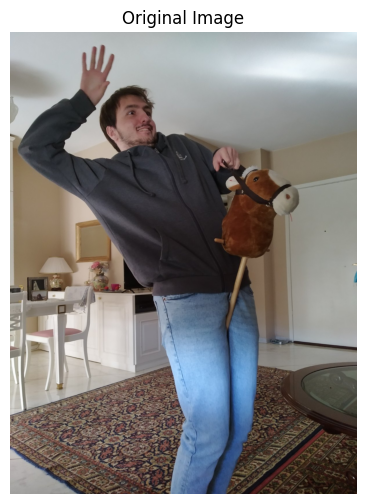

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from skimage.util import view_as_blocks
import heapq
from collections import defaultdict
import urllib.request

image = cv2.imread('horse_rider.png')
# image = cv2.imread('rider_square.png')
# image = cv2.resize(image, (256,256))

print(f'The shape of input image is: {image.shape}\n')

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
y, cr, cb = cv2.split(ycrcb_image)

Cr_downsampled= cr[::2,::2]
Cb_downsampled= cb[::2,::2]

2) Εφαρμογή 2D-DCT μετασχηματισμού στην downsampled YCbCr εικόνα και κβάντιση για καλύτερη συμπίεση.

In [54]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')


def quantize(block, q_matrix):
    return np.round(block / q_matrix)


def process_channel(channel, q_matrix):
    blocks = view_as_blocks(channel, block_shape=(8, 8))
    processed_blocks = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            block = blocks[i, j]
            dct_block = dct2(block - 128)
            quant_block = quantize(dct_block, q_matrix)
            processed_blocks[i, j] = quant_block
    return processed_blocks


# Standard ποιότητα (standard συμπίεση)
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Υψηλότερη ποιότητα (χειρότερη συμπίεση)
QY_high = np.array([
    [8, 6, 5, 8, 12, 20, 26, 31],
    [6, 6, 7, 10, 13, 29, 30, 28],
    [7, 7, 8, 12, 20, 29, 35, 28],
    [7, 9, 12, 15, 26, 44, 40, 31],
    [9, 12, 19, 28, 34, 55, 52, 39],
    [12, 18, 28, 32, 40, 52, 56, 46],
    [25, 32, 39, 44, 52, 61, 60, 51],
    [36, 46, 48, 49, 56, 50, 52, 50]
])

# Χαμηλότερη ποιότητα (καλύτερη συμπίεση)
QY_low = np.array([
    [32, 22, 20, 32, 48, 80, 102, 122],
    [24, 24, 28, 38, 52, 116, 120, 110],
    [28, 26, 32, 48, 80, 114, 138, 112],
    [28, 34, 44, 58, 102, 174, 160, 124],
    [36, 44, 74, 112, 136, 218, 206, 154],
    [48, 70, 110, 128, 162, 208, 226, 184],
    [98, 128, 156, 174, 206, 242, 240, 202],
    [144, 184, 190, 196, 224, 200, 206, 198]
])

QC = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

Y_processed = process_channel(y.astype('int'), QY)
Cb_processed = process_channel(Cb_downsampled.astype('int'), QC)
Cr_processed = process_channel(Cr_downsampled.astype('int'), QC)

3) Χωρική οπτικοποίηση των συντελεστών DCT. Προβολή ανακατασκευασμένης αρχικής εικόνας μόνο από τους DC συντελεστές όλων των DCT block.

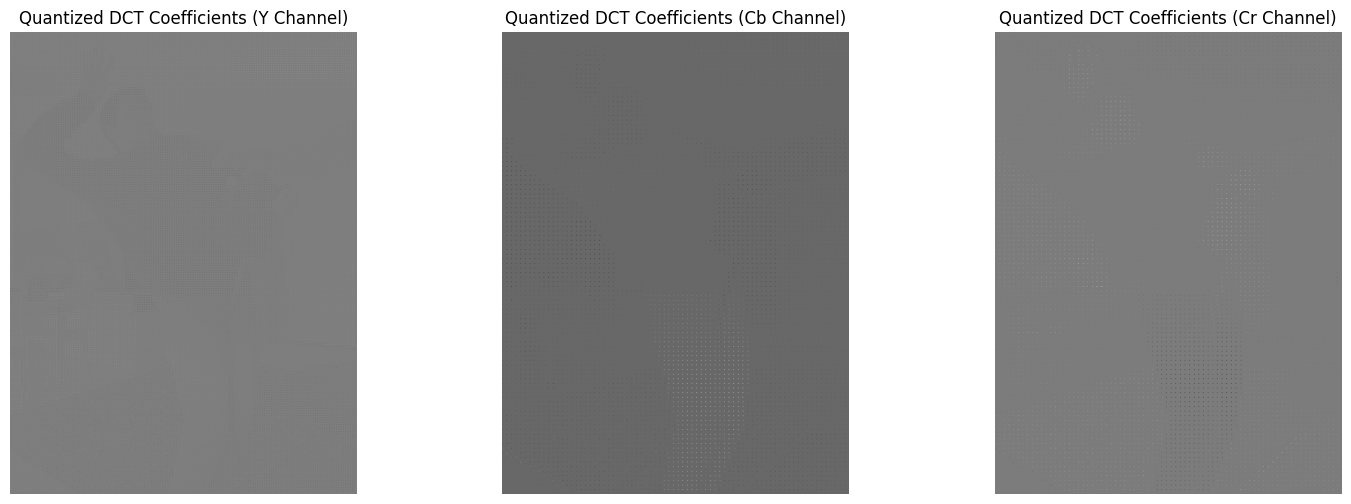

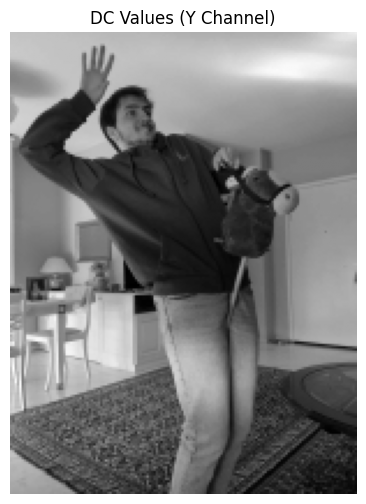

In [71]:
def visualize_quantized_dct(processed_blocks):
    reconstructed_image = np.zeros((processed_blocks.shape[0] * 8, processed_blocks.shape[1] * 8))
    for i in range(processed_blocks.shape[0]):
        for j in range(processed_blocks.shape[1]):
            block = processed_blocks[i, j]
            for m in range(8):
                for n in range(8):
                    reconstructed_image[i * 8 + m, j * 8 + n] = block[m, n]
    return reconstructed_image

visualized_dct_Y = visualize_quantized_dct(Y_processed)
visualized_dct_Cb= visualize_quantized_dct(Cb_processed)
visualized_dct_Cr = visualize_quantized_dct(Cr_processed)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(visualized_dct_Y, cmap='gray')
plt.title('Quantized DCT Coefficients (Y Channel)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualized_dct_Cb, cmap='gray')
plt.title('Quantized DCT Coefficients (Cb Channel)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(visualized_dct_Cr, cmap='gray')
plt.title('Quantized DCT Coefficients (Cr Channel)')
plt.axis('off')

plt.show()

flatten_blocks = Y_processed.reshape(Y_processed.shape[0], Y_processed.shape[1], -1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(flatten_blocks[:,:,0], cmap='gray')
plt.title('DC Values (Y Channel)')
plt.axis('off')
plt.show()


4) Εφαρμογή των εκτιμητών (1ο βήμα διαφορικής κωδικοποίησης) στις DC συνιστώσες όλων των DCT blocks:

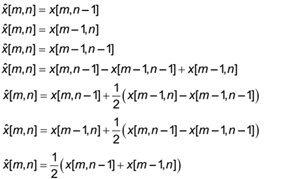


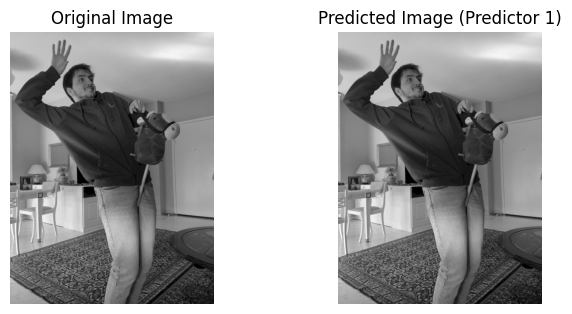

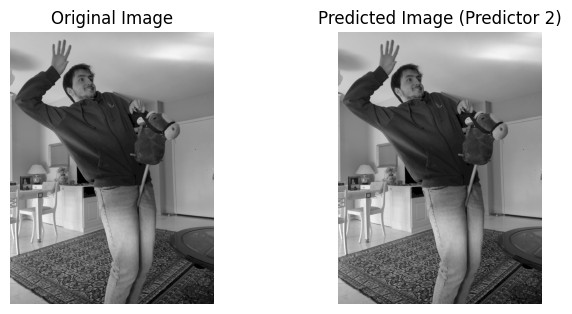

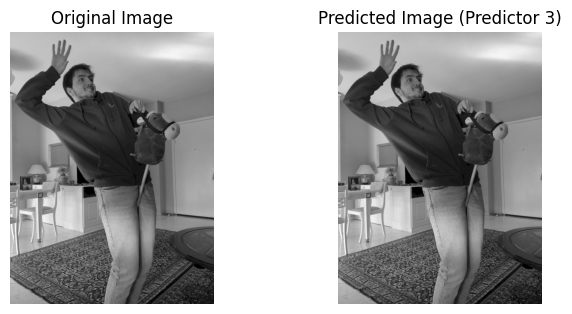

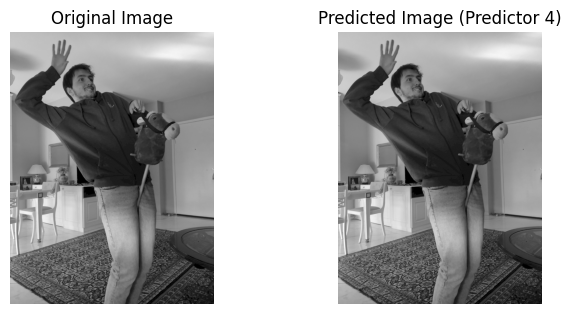

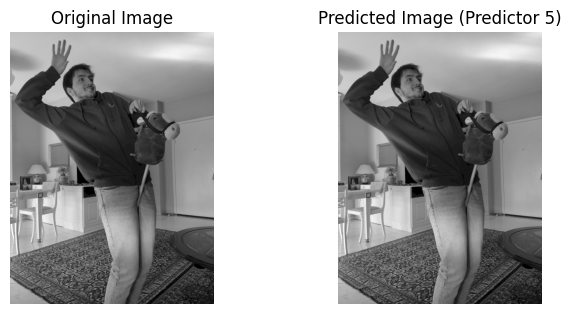

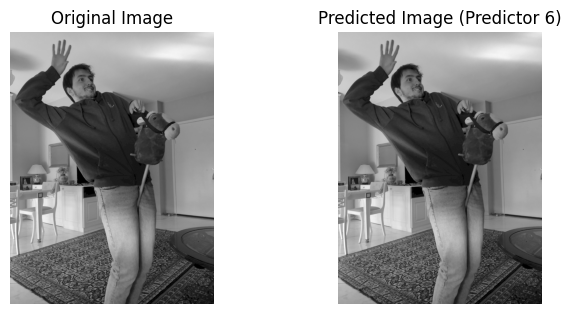

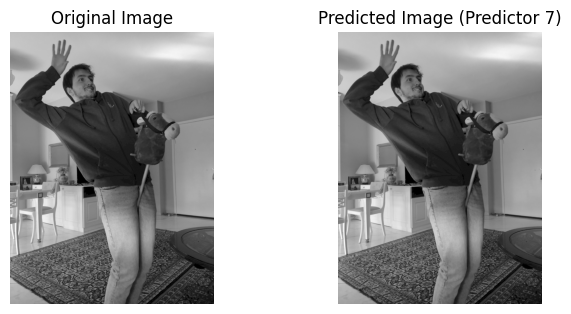

In [7]:
# Ορισμός των εκτιμητών της εικόνας του παραπάνω block κειμένου (ορισμός με την
# ίδια σειρά που απεικονίζονται)
predictor1_mask=np.array([[0, 0 ,0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor2_mask=np.array([[0, 1, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor3_mask=np.array([[1, 0, 0],
                          [0, 0, 0],
                          [0, 0, 0]])

predictor4_mask=np.array([[-1, 1, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor5_mask=np.array([[-0.5, 0.5, 0],
                          [1, 0, 0],
                          [0, 0, 0]])

predictor6_mask=np.array([[-0.5, 1, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor7_mask=np.array([[0, 0.5, 0],
                          [0.5, 0, 0],
                          [0, 0, 0]])

predictor_masks = [predictor1_mask, predictor2_mask, predictor3_mask,
                   predictor4_mask, predictor5_mask, predictor6_mask,
                   predictor7_mask]


predicted_images = []

for i, predictor_mask in enumerate(predictor_masks):

  predicted_image = cv2.filter2D(image, -1, predictor_mask)
  predicted_images.append(predicted_image)

  plt.figure(figsize=(12, 12))

  plt.subplot(3, 3, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(3, 3, 2)
  plt.imshow(predicted_image, cmap='gray')
  plt.title(f'Predicted Image (Predictor {i+1})')
  plt.axis('off')

  plt.show()

2) Υπολογισμός για κάθε predictor του σφάλματος, του ιστογράμματος και της εντροπίας του σφάλματος. Επιλογή του εκτιμητή με την χαμηλότερη εντροπία σφάλματος.

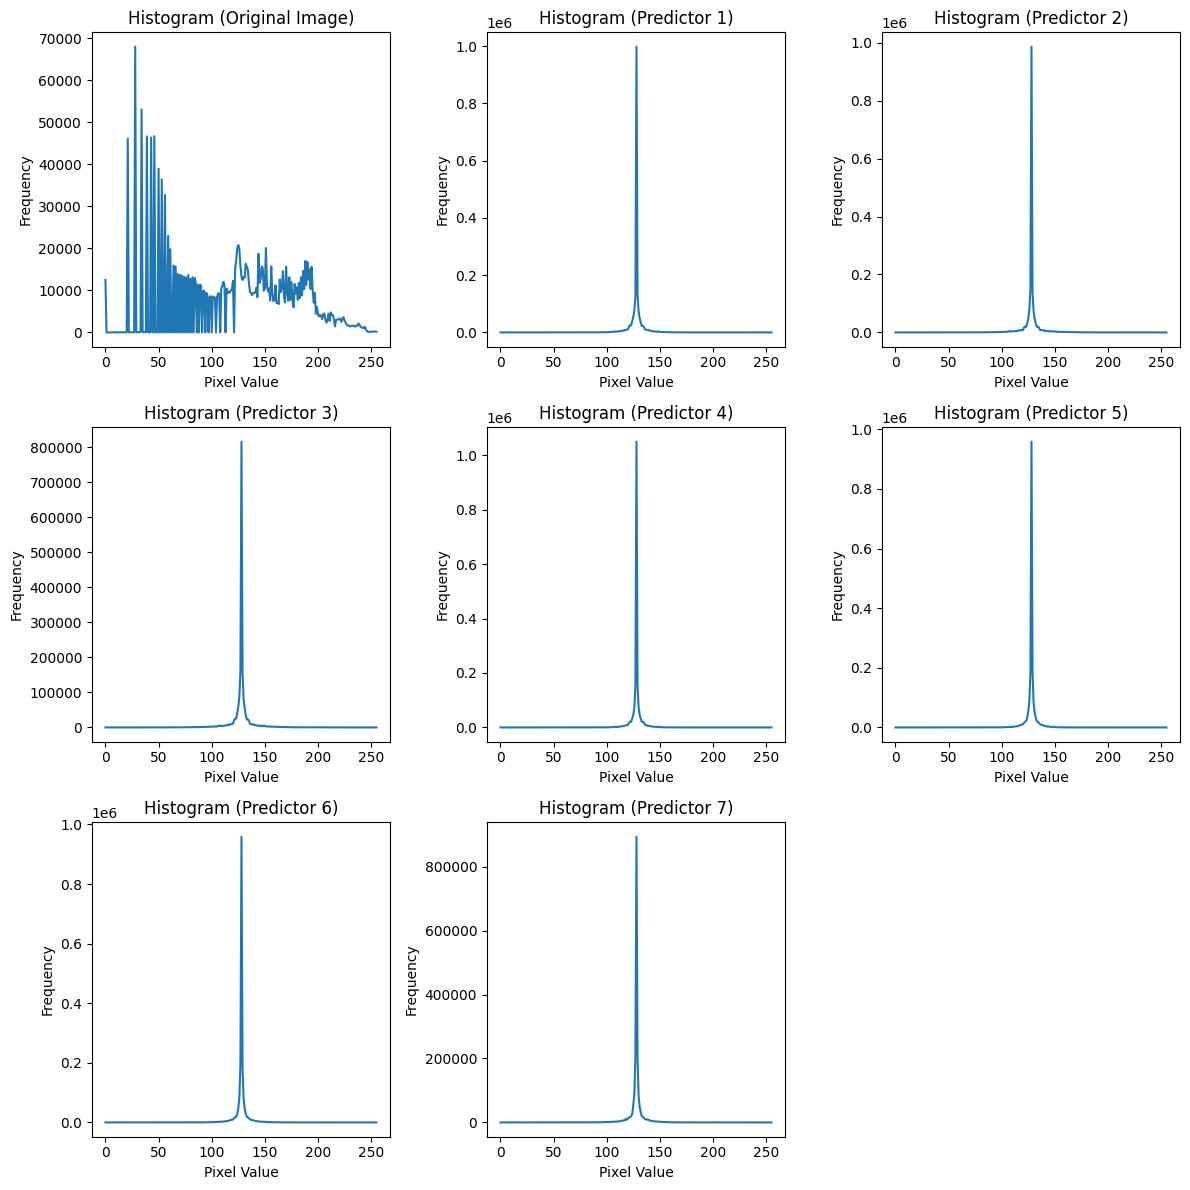


Entropy for Original image: 7.0263
Entropy for Predictor 1: 3.2431
Entropy for Predictor 2: 3.3518
Entropy for Predictor 3: 3.8504
Entropy for Predictor 4: 2.9286
Entropy for Predictor 5: 3.0752
Entropy for Predictor 6: 3.1169
Entropy for Predictor 7: 3.2718

Best Predictor (lowest entropy): Predictor 4 (Entropy = 2.9286)
Predictor 4:
[[-1  1  0]
 [ 1  0  0]
 [ 0  0  0]]


In [10]:
def compute_entropy(histogram):

    histogram_norm = histogram / np.sum(histogram)
    entropy_value = -np.sum(histogram_norm * np.log2(histogram_norm + 1e-10))  # Η μικρή ποσότητα για αποφυγή Not a number

    return entropy_value


histogram_original,_ = np.histogram(image, bins= 256,range = (0,255))
entropy_original = compute_entropy(histogram_original)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.plot(histogram_original)
plt.title(f'Histogram (Original Image)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

prediction_errors = []
entropies = []

for i, predicted_image in enumerate(predicted_images):

  prediction_error = image.astype(int) - predicted_image.astype(int)
  prediction_errors.append(prediction_error)

  histogram_pred, _ = np.histogram(prediction_error.flatten(), bins= 256,range = (-128,128))

  entropy = compute_entropy(histogram_pred)
  entropies.append(entropy)

  plt.subplot(3, 3, i+2)
  plt.plot(histogram_pred)
  plt.title(f'Histogram (Predictor {i+1})')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


print()
print(f'Entropy for Original image: {entropy_original:.4f}')

for i, entropy in enumerate(entropies):
    print(f'Entropy for Predictor {i+1}: {entropy:.4f}')

min_entropy = min(entropies)
min_ind = entropies.index(min_entropy)

print()
print(f'Best Predictor (lowest entropy): Predictor {min_ind + 1} (Entropy = {min_entropy:.4f})')
print(f'Predictor {min_ind + 1}:')
print(predictor_masks[min_ind])
